In [1]:
import networkx as nx
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import community
from sentiment_analysis.sent_analysis import get_sents

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Magnus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
# import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from textwrap import wrap
import networkx as nx
from tqdm import tqdm
import os
from urllib.parse import urlparse, unquote
import pickle
import re
from networkx.algorithms import bipartite
from datetime import datetime
from glob import glob
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import community as community_louvain
from collections import Counter
import pandas as pd
import scipy.stats as ss
import powerlaw

In [3]:
# Bingbot header
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"} 

# HTML contect handler. To prevent DDOS of targetm,
# as well as speedup concurrent runs, it stores the html content locally,
# and reads from there if the queried files are available.
def get_html_content(url, save_dir):
    # Parse the URL to get the path
    parsed_url = urlparse(url)
    # Decode any percent-encoded characters in the path
    path = unquote(parsed_url.path)
    
    # Remove the leading and trailing slashes and replace remaining slashes with underscores
    filename = path.strip('/').replace('/', '_') + '.html'
    
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define the path for the file
    file_path = os.path.join(save_dir, filename)

    # Check if the file already exists
    if not os.path.isfile(file_path):
        # If not, make a request and save the file
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(response.text)
            soup = BeautifulSoup(response.text, "html.parser")
            return soup
        elif response.status_code in [404, 403]:
            print(f"Response code: {response.status_code} for {url}")
        else:
            return None
    else:
        # If the file exists, read it from the disk
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        soup = BeautifulSoup(content, "html.parser")
        return soup


In [4]:

# function for scraping the relevant text elements from the hestenettet specific HTML architecture
def author_text_scrape(soup):
    author_list = []
    text_list = []
    # Find all the <td> elements with class "light" and itemprop="text"
    td_elements = soup.find_all('td', bgcolor='#787878', valign='top')

    # Iterate through the <td> elements
    for td in td_elements:
        # Extract the author's href number
        author_a = td.find('a', itemprop='url')
        if author_a:
            author_href = author_a['href']
            author_text = author_a.text
            
        else:
            author_href = None
            author_text = td.find('span', itemprop='name').text
        # print(author_text)
        # Find the first <div> with class "rsPost" within the current <td>
        rs_post = td.find('div', class_='rsPost')
        
        if rs_post:
            # Extract Danish text within <span> tags
            danish_text = [span.text for span in rs_post.find_all('p')]
            
            # Combine the text into a single string
            danish_text = "\n".join(danish_text)
                
            # if len(danish_text)>1 and author_text:
                # author_list.append(author_href.split('/')[-2])
            author_list.append(author_text)
            text_list.append(danish_text)
        # if author_text == "Doctor Who" and len(author_list)<2:
        #     print(rs_post)

    return author_list, text_list


In [5]:

# Helper function to extract timestamps and tags of hestenettet posts using BS4
date_format = "%d-%m-%y %H:%M"
def extract_timestamp_and_tag_of_post(soup):
    rows = soup.find_all('tr', {'valign': 'middle'})

    for row in rows:
        # Find all <td> elements with class 'light' within each row
        light_tds = row.find_all('td', class_='light')
        b_element = light_tds[1].find('span').find('b')
        tag = b_element.text
        # Select the last <td> element if it exists
        if light_tds:
            last_light_td = light_tds[-1]
            # Do something with last_light_td, e.g., print it
            return datetime.strptime(last_light_td.text,date_format),tag
       

In [6]:
 
html_dir = './html_scrape' # local dir for downloaded html elements
# Very inefficient list containers
href_list = []
post_title_list = []
timestamp_list = []
post_tag_list = []
# Specify the amount of post wanted
amount_of_post = int(10500/2+1) #for all available data use: int(# 185780+1) 

# Loops through the index pages of Hyggesnak and collects all the subpage adresses,
# as well as metadata for post node attributes.
for page_index in tqdm(range(70,amount_of_post,70)): 
    soup = get_html_content(f"https://www.heste-nettet.dk/forum/1/{page_index}/",html_dir)
    post_links = soup.find_all("a",href=True)
    timestamp,post_tag = extract_timestamp_and_tag_of_post(soup)

    # Filter  links
    for link in post_links:
        href = link['href']
        if "/forum/1/" in href and len(href.split("/"))==6:
            href_list.append(href)
            post_title_list.append(link.text)
            timestamp_list.append(timestamp)
            post_tag_list.append(post_tag)

 31%|███       | 23/75 [00:00<00:02, 25.54it/s]


KeyboardInterrupt: 

In [ ]:
# Another unnecesarily inefficient list storage architecture
authors_data = []
texts_data = []
used_href_list = []
used_titles_list = []
used_timestamps_list = []
used_tag_list = []
# Loops through all the collected page adresses and scrapes the text and authors using the helper function
for idx,href in enumerate(tqdm(href_list)):
    url = f"https://www.heste-nettet.dk{href}"
    if (soup:=get_html_content(url,html_dir)):
        author_list, text_list = author_text_scrape(soup)
        if len(author_list)>0 and len(text_list)>0:
            authors_data.append(author_list)
            texts_data.append(text_list)
            used_href_list.append(href)
            used_titles_list.append(post_title_list[idx])
            used_timestamps_list.append(timestamp_list[idx])
            used_tag_list.append(post_tag_list[idx])

100%|██████████| 5250/5250 [31:00<00:00,  2.82it/s]


In [ ]:
# Helper function to prepare the text for node attributes.
def clean_and_concatenate(data):
    # Remove empty strings
    data = [s for s in data if s.strip()]

    # Normalize whitespace and replace non-breaking spaces
    cleaned_data = [re.sub(r'\s+', ' ', s.replace('\xa0', ' ')).strip() for s in data]

    # Concatenate the strings into a single text
    concatenated_text = ' '.join(cleaned_data)
    return concatenated_text

def clean_string(s):
    return re.sub(r'\s+', ' ', s.replace('\xa0', ' ')).strip()

In [ ]:
# Generation of the BiPartite graph
G = nx.Graph()
# Keep track of added nodes
added_authors = set()
# Process each webpage
for idx, (authors, text_sections) in enumerate(zip(authors_data, texts_data)):

    # Extract corresponding data
    post_node = used_href_list[idx]
    title_of_post = used_titles_list[idx]
    post_text = clean_and_concatenate(texts_data[idx])
    post_timestamp = used_timestamps_list[idx]
    post_tag = used_tag_list[idx]
    # Create nodes
    new_authors = [author for author in authors if  not G.has_node(author)]
    G.add_nodes_from(new_authors,bipartite=0,OP_author=0, text='')

    G.add_node(post_node,bipartite=1,title=title_of_post,text=post_text,timestamp = post_timestamp,tag=post_tag)

    # Create edges:
    for text_idx, author in enumerate(authors):
        G.add_edge(author,post_node)
        G.nodes[author]['text'] += clean_string(texts_data[idx][text_idx])

    #Track how many times a person has made a post
    op_author = authors[0]
    G.nodes[op_author]["OP_author"] += 1

In [ ]:
# When the graph is generated, the largest connected component is extracted,
# and saved as a pickle object for use in analysis.
C_G = nx.connected_components(G)
graph_list = [(len(graph),graph) for graph in C_G]
all_lens = [length for (length,nodes) in graph_list]
max_idx = np.argmax(all_lens)
size_larg, largest_subgraph = graph_list[max_idx]
G_connected = G.subgraph(largest_subgraph).copy()

with open(f'Bipartite_G_5251_cutoff_v3.pkl', 'wb') as f:
    pickle.dump(G_connected, f)

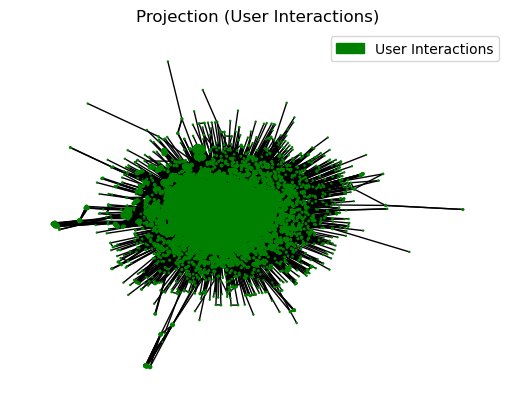

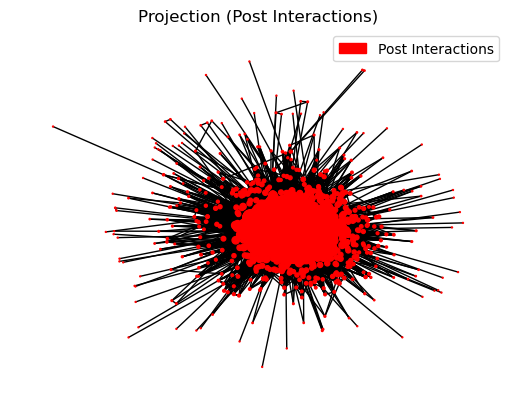

In [ ]:
# Using the bipartite algorithm the projections of the user and post parts of the graph is done

U, V = bipartite.sets(G_connected)
U_projected = bipartite.projected_graph(G_connected, U)
V_projected = bipartite.projected_graph(G_connected, V)
U_degrees = [U_projected.degree(n) for n in U_projected]
V_degrees = [V_projected.degree(n) for n in V_projected]

scale_factor = 0.5

plt.figure()
plt.title("Projection (User Interactions)")
nx.draw(U_projected, 
        node_color='green', 
        node_size=[d * scale_factor for d in U_degrees], 
        with_labels=False)

green_patch = mpatches.Patch(color='green', label='User Interactions')
plt.legend(handles=[green_patch])

plt.figure()
plt.title("Projection (Post Interactions)")
nx.draw(V_projected, 
        node_color='red', 
        node_size=[d * scale_factor for d in V_degrees], 
        with_labels=False)

red_patch = mpatches.Patch(color='red', label='Post Interactions')
plt.legend(handles=[red_patch])
plt.show()


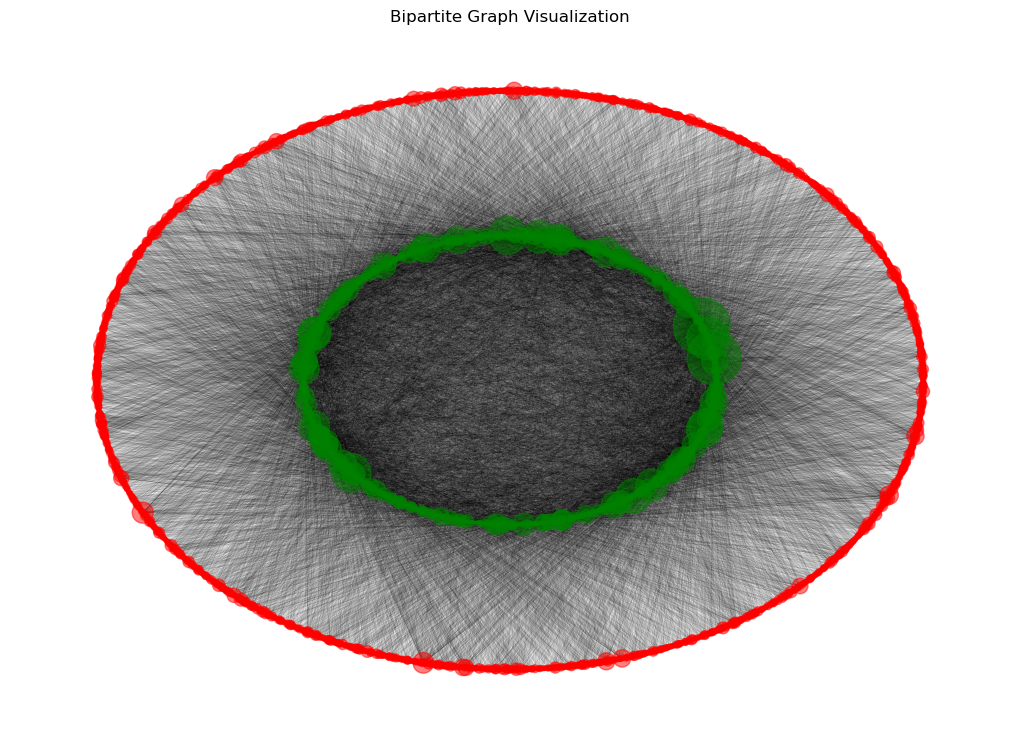

In [ ]:
# Plotting function for the bipartite graph:
def plot_bipartite_graph(bipartite_graph):
    # Extract the sets of nodes in each bipartite set
    top_nodes = {n for n, d in bipartite_graph.nodes(data=True) if d['bipartite'] == 0}
    bottom_nodes = set(bipartite_graph) - top_nodes

    # Choose a layout algorithm suitable for bipartite graphs
    # pos = nx.bipartite_layout(bipartite_graph, top_nodes)
    # pos = nx.spring_layout(bipartite_graph, pos=pos, seed=42, dim=2)
    pos = nx.shell_layout(bipartite_graph, nlist=[top_nodes, bottom_nodes])

    # Define colors for nodes in each partition
    colors = ['green' if n in top_nodes else 'red' for n in bipartite_graph.nodes]
    
    # Define sizes for nodes based on their degree
    node_sizes = [2.0 * bipartite_graph.degree[node] for node in bipartite_graph.nodes]

    plt.figure(figsize = (10,7))
    # Plot the bipartite graph with different node colors
    nx.draw(bipartite_graph, pos=pos, with_labels=False, font_weight='bold', node_size=node_sizes, node_color=colors, width = 0.03, alpha=0.5)

    plt.title("Bipartite Graph Visualization")
    plt.show()

plot_bipartite_graph(G)

In [ ]:
# Code used to generate the sub-sample of the full bipartite graph
# Notice you need to load in a pickle of the smaller sample
with open('210_node_bi_graph_v2.pkl', 'rb') as f:
    G_small = pickle.load(f)

plt.figure(figsize=(18, 10))
node_sizes = [G_small.degree(node) * 5  for node in G_small.nodes()]

# Assign colors: green for users (U), red for posts (V)
node_colors = ['green' if node in U else 'red' for node in G_small.nodes()]
pos = nx.spring_layout(G_small, k=0.1)
# Draw the graph
plt.title("Smaller extract of Bipartite Graph")
nx.draw(G_small,pos=pos, node_size=node_sizes, node_color=node_colors, with_labels=False)
plt.legend()
red_patch = mpatches.Patch(color='red', label='Posts')
green_patch = mpatches.Patch(color='green', label='Users')
plt.legend(handles=[red_patch,green_patch])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '210_node_bi_graph_v2.pkl'

# Network analysis

In [ ]:
def degree_distribution(t, b, bins = 50):
    
    normalize = lambda x: x / np.std(x)
    
    degree_count_t = normalize(list(dict(nx.degree(t)).values()))
    degree_count_b = normalize(list(dict(nx.degree(b)).values()))
    
    plt.figure(figsize=(10,5))
    plt.tight_layout()
    
    plt.subplot(1, 2, 1)
    plt.hist(degree_count_t, color="b", bins=bins)
    plt.ylim([0,4000])
    plt.xlim([0,max(max(degree_count_t), max(degree_count_b))])
    plt.title("Users Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    
    plt.subplot(1, 2, 2)
    plt.hist(degree_count_b, color="r", bins=bins)
    plt.ylim([0,4000])
    plt.xlim([0,max(max(degree_count_t), max(degree_count_b))])
    plt.title("Posts Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")

    plt.show()
    
degree_distribution(U, V)

ER = nx.erdos_renyi_graph(n = len(G.nodes), p = p)
degree_distribution(G, ER, 50)

In [ ]:
vals_g = list(dict(nx.degree(G)).values())
vals_er = list(dict(nx.degree(ER)).values())
vals_u = list(dict(nx.degree(U)).values())
vals_p = list(dict(nx.degree(V)).values())

print(ss.ttest_ind(vals_g, vals_er, nan_policy='omit'))
print(ss.ttest_ind(vals_u, vals_p, nan_policy='omit'))

In [ ]:
def power_law_analysis(graphs):
    fig, ax = plt.subplots(2, 2, figsize=(12, 7))
    for i, graph in enumerate(graphs):
        # Extract the degree sequence from the graph
        degree_sequence = [d for n, d in graph.degree()]

        # Fit the power-law distribution to the degree sequence
        fit = powerlaw.Fit(degree_sequence)

        fit.plot_pdf(ax=ax[i, 0], color='b', linestyle='--', label='fit PDF: alpha {:.2f}'.format(fit.power_law.alpha))
        fit.power_law.plot_pdf(ax=ax[i, 0], color='b', linestyle='-', label='power-law PDF')

        fit.plot_cdf(ax=ax[i, 1], color='r', linestyle='--', label='fit CDF')
        fit.power_law.plot_cdf(ax=ax[i, 1], color='r', linestyle='-', label='power-law CDF')

        ax[i, 0].set_title('Degree Distribution (PDF)')
        ax[i, 1].set_title('Cumulative Degree Distribution (CDF)')

        for axis in ax[1]:
            axis.legend()
        for axis in ax[0]:
            axis.legend()

    plt.tight_layout()
    plt.show()

power_law_analysis([U,V])

In [ ]:
def centrality_analysis(graph):
    closeness_centrality = nx.closeness_centrality(graph)
    plt.hist(closeness_centrality.values(), bins=100)
    plt.show()
    
    print(sorted(list(closeness_centrality.items()), key=lambda x: x[1], reverse=True))
    print(np.mean(list(closeness_centrality.values())))

centrality_analysis(U)
centrality_analysis(V)

# Sentiment analysis

In [ ]:
with open('Bipartite_G_5251_cutoff_v3.pkl', 'rb') as f:
    G = pickle.load(f)

In [ ]:
# extract all posts from graph
texts = nx.get_node_attributes(G, 'text')

# Compute sentiment scores for each node
sentiment_scores = get_sents(texts)

# Feed sentiment scores back into the nodes of the graph
for node, sentiment in sentiment_scores.items():
    # Check if the node exists to be extra cautious, though this should always be true
    if G.has_node(node):
        nx.set_node_attributes(G, {node: sentiment}, 'sentiment')

with open(f'Bipartite_G_5251_cutoff_v3_with_sentiments.pkl', 'wb') as f:
    pickle.dump(G, f)

100%|██████████| 10577/10577 [10:54<00:00, 16.17it/s] 


Average Sentiment for Users: 0.7073538199128669
Median Sentiment for Users: 0.7055427251732102
Q1 Sentiment for Users: 0.0
Q3 Sentiment for Users: 1.2083333333333333
Average Sentiment for Posts: 0.7976489567573478
Median Sentiment for Posts: 0.7916666666666666
Q1 Sentiment for Posts: 0.42847985347985346
Q3 Sentiment for Posts: 1.1818181818181819


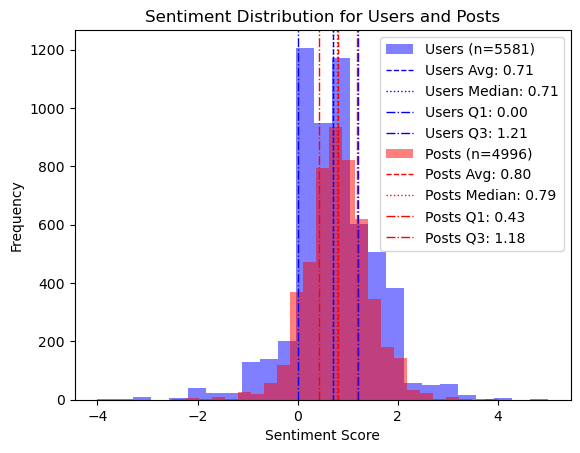

In [58]:
with open('Bipartite_G_5251_cutoff_v3_with_sentiments.pkl', 'rb') as f:
    G = pickle.load(f)

sentiment_scores = nx.get_node_attributes(G,'sentiment')

U, V = bipartite.sets(G)
U_projected = bipartite.projected_graph(G, U)
V_projected = bipartite.projected_graph(G, V)

user_graph = U_projected
post_graph = V_projected
def plot_sentiment_distribution(sentiments, category, color,full_measure=True):
    """Plots the sentiment distribution and its statistical measures."""
    avg = np.mean(sentiments)
    median = np.median(sentiments)
    q1 = np.percentile(sentiments, 25)
    q3 = np.percentile(sentiments, 75)

    plt.hist(sentiments, bins=25, alpha=0.5, color=color, label=f'{category} (n={len(sentiments)})')
    plt.axvline(avg, color=color, linestyle='dashed', linewidth=1, label=f'{category} Avg: {avg:.2f}')
    if full_measure:
        plt.axvline(median, color=color, linestyle='dotted', linewidth=1, label=f'{category} Median: {median:.2f}')
        plt.axvline(q1, color=color, linestyle='dashdot', linewidth=1, label=f'{category} Q1: {q1:.2f}')
        plt.axvline(q3, color=color, linestyle='dashdot', linewidth=1, label=f'{category} Q3: {q3:.2f}')

    # Print statistical measures
    print(f"Average Sentiment for {category}:", avg)
    if full_measure:
        print(f"Median Sentiment for {category}:", median)
        print(f"Q1 Sentiment for {category}:", q1)
        print(f"Q3 Sentiment for {category}:", q3)

# Assuming G is your graph and sentiment_scores is a dictionary with sentiments
node_att = nx.get_node_attributes(G, 'bipartite')

# Separating sentiment scores for users and posts
user_sents = [sentiment for node, sentiment in sentiment_scores.items() if node_att[node] == 0]
post_sents = [sentiment for node, sentiment in sentiment_scores.items() if node_att[node] == 1]

# Plotting
plot_sentiment_distribution(user_sents, 'Users', 'blue')
plot_sentiment_distribution(post_sents, 'Posts', 'red')

plt.legend()
plt.title('Sentiment Distribution for Users and Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [67]:
print(ss.ttest_ind(user_sents,post_sents))

TtestResult(statistic=-6.126735741227783, pvalue=9.289384929306135e-10, df=10575.0)


In [86]:
actual_user_mean = np.mean(user_sents)
actual_post_mean = np.mean(post_sents)
n_simulations = 10000

count = 0

for _ in range(n_simulations):
    shuffled_sentiments = np.random.permutation(np.concatenate((user_sents, post_sents)))
    shuffled_user = shuffled_sentiments[:len(user_sents)]
    shuffled_post = shuffled_sentiments[len(user_sents):]
    
    shuffled_user_mean = np.mean(shuffled_user)
    shuffled_post_mean = np.mean(shuffled_post)
    
    if abs(shuffled_user_mean - actual_user_mean) >= abs(shuffled_post_mean - actual_post_mean):
        count += 1

p_value = count / n_simulations

if p_value < 0.05:
    result = "Reject the null hypothesis: There is a significant difference in sentiment between users and posts."
else:
    result = "Fail to reject the null hypothesis: No significant difference in sentiment."

result, p_value

('Reject the null hypothesis: There is a significant difference in sentiment between users and posts.',
 0.0)

# Communities


In [10]:

# Partitioning of post projection using tags.
attribute = 'tag'  
partition = {node: data[attribute] for node, data in post_graph.nodes(data=True)}
modularity = community_louvain.modularity(partition, post_graph)
print("Modularity of the partition based on attribute: ", modularity)



Modularity of the partition based on attribute:  0.00605774908507099


In [11]:

unique_tags = set(nx.get_node_attributes(post_graph, attribute).values())
subgraphs = {tag: post_graph.subgraph([n for n, d in post_graph.nodes(data=True) if d.get(attribute) == tag]) for tag in unique_tags}

for tag, subgraph in subgraphs.items():
    if len(subgraph.nodes()) > 0:
        sub_partition = community_louvain.best_partition(subgraph)
        sub_modularity = community_louvain.modularity(sub_partition, subgraph)
        print(f"Modularity within '{tag}' tag: {sub_modularity}")
    else:
        print(f"No nodes with '{tag}' tag.")

Modularity within 'KULT' tag: 0.28498027185048
Modularity within 'MAD' tag: 0.20427931562025653
Modularity within 'HEST' tag: 0.23973593356314557
Modularity within 'VITT' tag: 0.2595391482422568
Modularity within 'VELF' tag: 0.20594944837964513
Modularity within 'UDDA' tag: 0.3136526334382913
Modularity within 'OT' tag: 0.24861275786781784
Modularity within 'NYHED' tag: 0.3652704498894381


In [18]:
best_user_partition = community_louvain.best_partition(user_graph)
best_post_partition = community_louvain.best_partition(post_graph)
best_user_mod = community_louvain.modularity(best_user_partition,user_graph)
best_post_mod = community_louvain.modularity(best_post_partition,post_graph)
number_of_user_partitions = len(set(best_user_partition.values()))
number_of_post_partitions = len(set(best_post_partition.values()))
print(f"Modularity of user partitions: {best_user_mod}, with {number_of_user_partitions} communities")
print(f"Modularity of post partitions: {best_post_mod}, with {number_of_post_partitions} communities")


Modularity of user partitions: 0.401966072256951, with 22 communities
Modularity of post partitions: 0.24768776995111158, with 5 communities


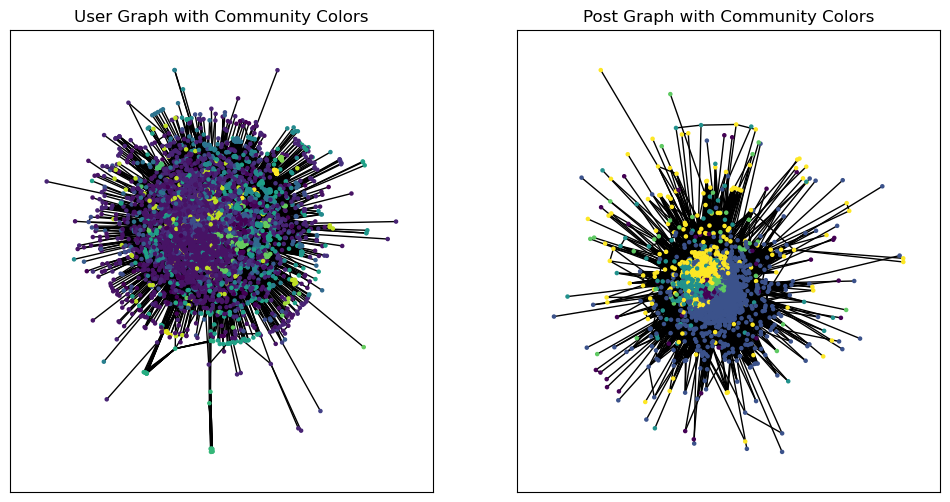

In [43]:
plt.figure(figsize=(12, 6))
size = 5
plt.subplot(1, 2, 1)
pos = nx.spring_layout(user_graph)  
user_colors = [best_user_partition[node] for node in user_graph]
nx.draw_networkx(user_graph, pos, node_color=user_colors, with_labels=False, node_size = size)
plt.title('User Graph with Community Colors')

plt.subplot(1, 2, 2)
pos = nx.spring_layout(post_graph)  
post_colors = [best_post_partition[node] for node in post_graph]
nx.draw_networkx(post_graph, pos, node_color=post_colors, with_labels=False, node_size = size)
plt.title('Post Graph with Community Colors')

plt.show()

Average Sentiment for Community 3: 0.7708371323230256
Average Sentiment for Community 0: 0.7256977368342472
Average Sentiment for Community 4: 0.811742150378376
Average Sentiment for Community 1: 0.8219648116555844
Average Sentiment for Community 2: 0.7937486696811415


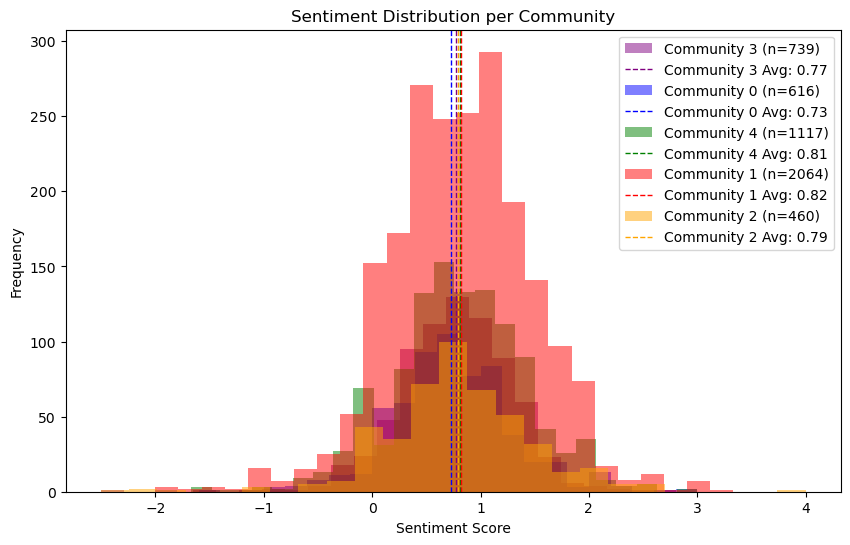

In [32]:
color = ['purple', 'blue', 'green', 'red','orange']
# Extracting sentiments from nodes and grouping by community
community_sentiments = {}
for node, data in post_graph.nodes(data=True):
    community = best_post_partition[node]
    sentiment = data['sentiment']  # Replace 'sentiment' with the actual attribute key
    community_sentiments.setdefault(community, []).append(sentiment)

# Plotting histograms
plt.figure(figsize=(10, 6))
for idx, (community, sentiment_scores) in enumerate(community_sentiments.items()):
    plot_sentiment_distribution(sentiment_scores,f'Community {community}',color[idx],full_measure=False)
    # plt.hist(sentiment_scores, bins=20, alpha=0.5, label=f'Community {community}')

plt.title('Sentiment Distribution per Community')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [70]:
post_graph.nodes['/forum/1/2421949/2421949/']

{'bipartite': 1,
 'title': 'Kælenavn...?',
 'text': 'Ja... jeg er begyndt at ride og passe den skønneste araber! hun hedder Alicia men kunne godt tænke mig et kælenavn... håber i kan hjælpe <3 Navne med to stavelser er som regel gode som kælenavne. Ud fra hendes navn kunne Ali være et bud Måske ejer allerede bruger et navn (eller hør om det er okay at du giver hesten et nyt) eller måske du kommer til at kalde hende Alice, men mon ikke det kommer helt af sig selv efter et stykke tid? Tak for svar! men nej ejer har intet og er helt ok med at jeg finder på et! er begyndt at kalde hende Ali og det hænger ved SaveSave jeg tænker at trump eller donald måske lyder mega nice <3 eller måske hillary, fordi det er en pige kys muleminna',
 'timestamp': datetime.datetime(2016, 10, 6, 21, 12),
 'tag': 'OT',
 'sentiment': 1.5333333333333334}

Modularity based on time

In [83]:
timedates = [data['timestamp'] for _, data in post_graph.nodes(data=True)]
min_time = min(timedates)
max_time = max(timedates)

# Convert timedates to a comparable format (e.g., timestamps)
timestamps = [td for td in timedates]
min_timestamp = min(timestamps)
max_timestamp = max(timestamps)
time_range = max_timestamp - min_timestamp

modularity_scores = []

# Iterate over different numbers of splits (4 to 20)
for n_splits in range(1, 21):
    # Determine the time range for each community
    split_duration = time_range / n_splits

    # Assigning nodes to communities based on timedate
    partition = {}
    for node, data in post_graph.nodes(data=True):
        timedate = data['timestamp']
        community = int((timedate - min_timestamp) / split_duration)
        partition[node] = community
    
    # Calculating modularity
    communities = list(set(partition.values()))
    modularity = community_louvain.modularity(partition,post_graph)
    modularity_scores.append((n_splits, modularity))

sorted(modularity_scores,key=lambda x:x[1],reverse=True)

AttributeError: 'tuple' object has no attribute 'values'

In [85]:
sorted(modularity_scores,key=lambda x:x[1],reverse=True)

[(8, 0.07231991169274847),
 (7, 0.07230435648292625),
 (9, 0.07087068837519417),
 (6, 0.0680913024313269),
 (4, 0.0661125657548633),
 (5, 0.06587072968728054),
 (10, 0.06465480936589736),
 (11, 0.05659702371117615),
 (3, 0.0549235605777792),
 (12, 0.05364112911014619),
 (13, 0.048870134578417816),
 (14, 0.04629801689806594),
 (15, 0.045953031697919346),
 (16, 0.04313417072889562),
 (17, 0.04236737680229001),
 (18, 0.042031474751564504),
 (19, 0.039651444495525004),
 (20, 0.038035098642281),
 (2, 0.03149807622700242),
 (1, 0.0008576667260877615)]

Average Sentiment for Community 0: 0.5406476775562115
Average Sentiment for Community 1: 0.7458182220566523
Average Sentiment for Community 2: 0.7839009182242614
Average Sentiment for Community 3: 0.7123126443452094
Average Sentiment for Community 12: 0.7213175674207419
Average Sentiment for Community 5: 0.756583333964494
Average Sentiment for Community 6: 0.6168589017304473
Average Sentiment for Community 7: 0.6138185143736524
Average Sentiment for Community 8: 0.6224975871473822
Average Sentiment for Community 9: 0.6328160719750326
Average Sentiment for Community 10: 0.6108140011505442
Average Sentiment for Community 11: 0.5255455986148172
Average Sentiment for Community 15: 0.49374686716791977
Average Sentiment for Community 16: 0.8600479618531932
Average Sentiment for Community 19: 0.5478437000586149
Average Sentiment for Community 20: 0.76
Average Sentiment for Community 21: 0.48014705882352937
Average Sentiment for Community 4: 0.5
Average Sentiment for Community 13: 0.6229519101

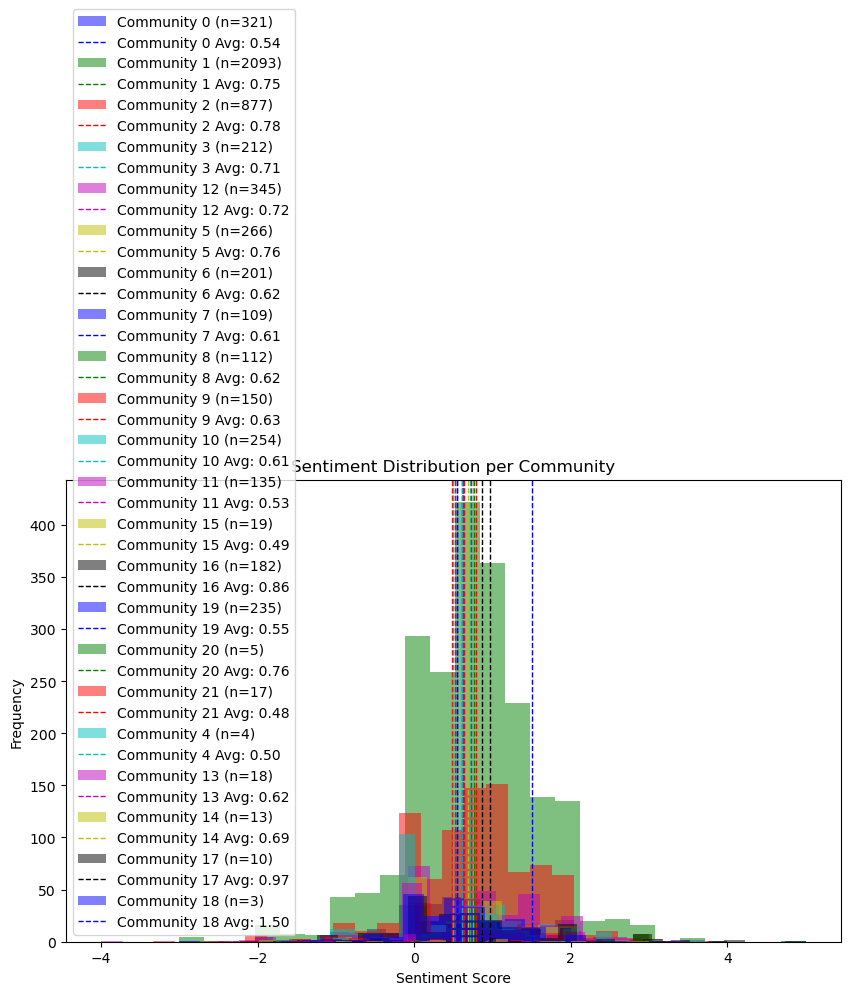

In [44]:
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']*4
# Extracting sentiments from nodes and grouping by community
community_sentiments = {}
for node, data in user_graph.nodes(data=True):
    community = best_user_partition[node]
    sentiment = data['sentiment']  # Replace 'sentiment' with the actual attribute key
    community_sentiments.setdefault(community, []).append(sentiment)

# Plotting histograms
plt.figure(figsize=(10, 6))
for idx, (community, sentiment_scores) in enumerate(community_sentiments.items()):
    plot_sentiment_distribution(sentiment_scores,f'Community {community}',color[idx],full_measure=False)
    # plt.hist(sentiment_scores, bins=20, alpha=0.5, label=f'Community {community}')

plt.title('Sentiment Distribution per Community')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [52]:
community_sentiments = {}
for node, data in user_graph.nodes(data=True):
    community = best_user_partition[node]
    sentiment = data['sentiment']  # Replace 'sentiment' with the actual attribute key
    community_sentiments.setdefault(community, []).append(sentiment)

# Calculating community sizes and average sentiments
community_data = {
    'Community': [],
    'Size': [],
    'Average Sentiment': []
}
for community, sentiments in community_sentiments.items():
    community_data['Community'].append(community)
    community_data['Size'].append(len(sentiments))
    community_data['Average Sentiment'].append(sum(sentiments) / len(sentiments))

# Creating a DataFrame for the LaTeX table
df = pd.DataFrame(community_data)

df_sorted = df.sort_values(by='Community', ascending=True)
latex_table = df_sorted.to_latex(index=False)

print(latex_table)

\begin{tabular}{rrr}
\toprule
Community & Size & Average Sentiment \\
\midrule
0 & 321 & 0.540648 \\
1 & 2093 & 0.745818 \\
2 & 877 & 0.783901 \\
3 & 212 & 0.712313 \\
4 & 4 & 0.500000 \\
5 & 266 & 0.756583 \\
6 & 201 & 0.616859 \\
7 & 109 & 0.613819 \\
8 & 112 & 0.622498 \\
9 & 150 & 0.632816 \\
10 & 254 & 0.610814 \\
11 & 135 & 0.525546 \\
12 & 345 & 0.721318 \\
13 & 18 & 0.622952 \\
14 & 13 & 0.687179 \\
15 & 19 & 0.493747 \\
16 & 182 & 0.860048 \\
17 & 10 & 0.970455 \\
18 & 3 & 1.500000 \\
19 & 235 & 0.547844 \\
20 & 5 & 0.760000 \\
21 & 17 & 0.480147 \\
\bottomrule
\end{tabular}

